In [3]:
import numpy as np
import pandas as pd
import sys
from catboost import CatBoostClassifier, CatBoostRegressor
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.model_selection import LearningCurveDisplay
import pickle

data_path = "/Users/weitongxuedemacbookpro/My-cirrhosis-project-deployment/cirrhosis-end-to-end/cirrhosis-data/"

In [4]:
df_train = pd.read_csv(data_path + "train_mod_v24.csv", index_col=0)
df_test = pd.read_csv(data_path + "test_mod_v24.csv", index_col=0)
df_train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,...,Symptom_Score_111010,Symptom_Score_111100,Liver_Function_Index,Risk_Score,Diag_Year,Diag_Month,PCA_0,PCA_1,PCA_2,PCA_3
0,999,1,21532,1,0,0,0,2.3,316.0,3.35,...,0,0,446.6125,-1595.35,2,8,3187.797358,-243.363648,-936.819898,-14.715766
1,2574,0,19237,0,0,0,0,0.9,364.0,3.54,...,0,0,394.8225,-1435.56,7,0,837.568664,-372.260271,557.758103,50.423388
2,3428,0,13727,0,0,1,1,3.3,299.0,3.55,...,0,0,288.8000,-1022.15,9,4,-4705.145822,-673.189927,1218.950873,-19.809820
3,2576,0,18460,0,0,0,0,0.6,256.0,3.50,...,0,0,432.1000,-1648.90,7,0,66.157624,-144.111216,538.278105,-75.057600
4,788,0,16658,0,0,1,0,1.1,346.0,3.65,...,0,0,327.8250,-1176.25,2,1,-1684.137676,-554.505946,-1316.469566,-20.806744


In [ ]:
# df_train.info()

In [5]:
FEATS = ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 
         'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage', 'Drug', 
         'Hepatomegaly', 'Spiders', 'Sex', 'Edema_N', 'Edema_S', 'Edema_Y']

LABEL = 'Status'
# FEATS = FEATS + pca_c_names
# FEATS = sel_feats.tolist()
print(f"Number of feats: {len(FEATS)}")
print(f"Features used: {FEATS}")

Number of feats: 21
Features used: ['Platelets', 'Copper', 'Alk_Phos', 'Diagnosis_Date', 'SGOT', 'Age', 'N_Days', 'Cholesterol', 'Tryglicerides', 'Albumin', 'Bilirubin', 'Prothrombin', 'Symptom_Score', 'Stage', 'Drug', 'Hepatomegaly', 'Spiders', 'Sex', 'Edema_N', 'Edema_S', 'Edema_Y']


In [6]:
df_train_final = df_train[FEATS+ [LABEL]]
df_test_final = df_test[FEATS]

In [7]:
df_train_final

,Platelets,Copper,Alk_Phos,Diagnosis_Date,SGOT,Age,N_Days,Cholesterol,Tryglicerides,Albumin,...,Symptom_Score,Stage,Drug,Hepatomegaly,Spiders,Sex,Edema_N,Edema_S,Edema_Y,Status
0,394.0,172.0,1601.0,20533,179.80,21532,999,316.0,63.0,3.35,...,1,2,1,0,0,1,1,0,0,2
1,361.0,63.0,1440.0,16663,134.85,19237,2574,364.0,88.0,3.54,...,1,2,0,0,0,0,1,0,0,0
2,199.0,131.0,1029.0,10299,119.35,13727,3428,299.0,50.0,3.55,...,3,3,0,1,1,0,0,0,1,2
3,269.0,58.0,1653.0,15884,71.30,18460,2576,256.0,96.0,3.50,...,1,2,0,0,0,0,1,0,0,0
4,298.0,63.0,1181.0,15870,125.55,16658,788,346.0,96.0,3.65,...,2,3,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8057,288.0,24.0,797.0,21194,91.00,22347,1153,246.0,113.0,3.58,...,2,1,1,1,0,0,1,0,0,0
8058,231.0,41.0,1166.0,20300,70.00,21294,994,260.0,82.0,2.75,...,1,1,0,0,0,0,1,0,0,0
8059,234.0,39.0,1713.0,21828,171.00,22767,939,434.0,100.0,3.35,...,1,1,1,0,0,0,1,0,0,0
8060,335.0,69.0,1050.0,13040,117.00,13879,839,247.0,88.0,3.16,...,1,1,1,0,0,0,1,0,0,0


In [ ]:
# conda install -c conda-forge catboost

In [ ]:
# pip install lightgbm

In [ ]:
# pip install cmake

In [ ]:
# pip install --upgrade pip

In [ ]:
# import lightgbm

In [ ]:
# conda install lightgbm

In [ ]:
# pip install optuna

# Best params

## XGBoost

In [8]:
# xgb_classifier = xgb.XGBClassifier()

X = df_train_final[FEATS]
y = df_train_final[LABEL]

def objective_xgb(trial):
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 300,750),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'min_child_weight': trial.suggest_float('min_child_weight', 2,50),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2, log = True),
        'subsample': trial.suggest_float('subsample', 0.2, 1),
        'gamma': trial.suggest_float('gamma', 1e-4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree',0.2,1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel',0.2,1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.2, 1)
    }
    
    xgb_optuna = xgb.XGBClassifier(**xgb_params, random_state= 42, n_jobs=-1)
    
    cv = abs(cross_val_score(xgb_optuna, X, y, cv=4,scoring="neg_log_loss").mean())
    
    return cv

In [ ]:
# %%time
# study = optuna.create_study(direction='minimize')
# study.optimize(objective_xgb, n_trials=100, timeout=2000)
# study.best_params

In [ ]:
# xgb best params

# {'n_estimators': 321,
#  'max_depth': 22,
#  'min_child_weight': 11.070726747842205,
#  'learning_rate': 0.04183999030897231,
#  'subsample': 0.8147003967290872,
#  'gamma': 0.24787119264200683,
#  'colsample_bytree': 0.497495857794794,
#  'colsample_bylevel': 0.3135559715722269,
#  'colsample_bynode': 0.871417488685748}


#lgb best params
# lgb_params = 
# {'n_estimators': 167,
#  'max_depth': 33,
#  'learning_rate': 0.035587236958871754,
#  'reg_alpha': 0.0063702400826607455,
#  'reg_lambda': 0.003622601223698469,
#  'min_child_weight': 0.5324716296617535,
#  'min_child_samples': 86,
#  'subsample': 0.6322679072761366,
#  'subsample_freq': 5,
#  'colsample_bytree': 0.2575403028982689,
#  'num_leaves': 34}


# catboost best params
# {'iterations': 440,
#  'depth': 8,
#  'min_data_in_leaf': 37,
#  'learning_rate': 0.066811646968983,
#  'random_strength': 0.10809515336656547}

## Catboost

In [10]:
from catboost import CatBoostClassifier

X = df_train_final[FEATS]
y = df_train_final[LABEL]

def objective_cat(trial):
    cat_params = {
    'iterations': trial.suggest_int('iterations', 100,600),
    'depth': trial.suggest_int('depth', 3, 50),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2,50),
    'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2, log = True),
#     'subsample': trial.suggest_float('subsample', 0.2, 1),
    #'rsm': trial.suggest_float('rsm',0.2,1),
    'random_strength':trial.suggest_float('random_strength', 5e-3, 0.3)
    }
    cb_optuna = CatBoostClassifier(**cat_params, random_state = 42, 
                                   grow_policy = 'Lossguide', 
                                   #allow_writing_files=False
                                  )

    cv = abs(cross_val_score(cb_optuna, X, y, cv = 4,scoring='neg_log_loss').mean())
    return cv

Sorry for such a long answer. The error message means that you've possibly set subsample=XXX parameter somewhere (or that you trigger some bug 😄)
By now, Bayesian bootstrap is fully supported both on CPU and GPU and it's default bootstrap for GPU. Provided code snippet works just fine on my data.
So, please, can you reopen this issue if problem still occurs on your data and send us a code snippet for problem reproduction?

In [ ]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(objective_cat, n_trials=50, timeout=1000)
study.best_params

## LGBM

In [11]:
import optuna
def objective(trial):
    lgb_params = {
        'n_estimators' : trial.suggest_int('n_estimators',50,500),
        "max_depth":trial.suggest_int('max_depth',3,50),
        "learning_rate" : trial.suggest_float('learning_rate',1e-4, 0.25, log=True),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        "min_child_weight" : trial.suggest_float('min_child_weight', 0.5,4),
        "min_child_samples" : trial.suggest_int('min_child_samples',1,100),
        "subsample" : trial.suggest_float('subsample', 0.4, 1),
        "subsample_freq" : trial.suggest_int('subsample_freq',0,5),
        "colsample_bytree" : trial.suggest_float('colsample_bytree',0.2,1),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 64),
    }
    lgbmmodel_optuna = lgb.LGBMClassifier(**lgb_params, random_state=42)
    cv = abs(cross_val_score(lgbmmodel_optuna, X, y, cv = 4,scoring='neg_log_loss').mean())
    return cv

In [ ]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=2000)

In [ ]:
study.best_params

# Baseline Model

In [13]:
# len(X_train), len(X_val)

In [14]:
X = df_train_final[FEATS]
y = df_train_final[[LABEL]]

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=42)

In [15]:
def validate_models(models,
                    data: pd.DataFrame, 
                    label=LABEL,
                    n_splits=5,
                    n_repeats=1,
                    seed=43):
    train_scores, val_scores = {}, {}
    
    pbar = tqdm(models)
    for model in pbar:
        model_str = model["name"]
        model_est = model["model"]
        model_feats = model["feats"]
        
        pbar.set_description(f"Processing {model_str}...")
        
        train_scores[model_str] = []
        val_scores[model_str] = []
        skf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

        for i, (train_idx, val_idx) in enumerate(skf.split(data[model_feats], data[label])):
            pbar.set_postfix_str(f"Fold {i+1}/{n_splits}")
            
            X_train, y_train = data[model_feats].loc[train_idx], data[label].loc[train_idx]
            X_val, y_val = data[model_feats].loc[val_idx], data[label].loc[val_idx]
            
            if model_str in ["lgb_cl"]:
                callbacks = [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
                model_est.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=callbacks)
            elif model_str in ["xgb_cl", "cat_cl"]:
                model_est.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)
            elif model_str in ["voting_clf"]:
                pass # TODO: find a solution
            else:
                model_est.fit(X_train, y_train)
                
            train_preds = model_est.predict_proba(X_train[model_feats])
            valid_preds = model_est.predict_proba(X_val[model_feats])
            train_score = log_loss(y_train, train_preds)
            val_score = log_loss(y_val, valid_preds)
            train_scores[model_str].append(train_score)
            val_scores[model_str].append(val_score)
            
            #print(f"{model_str} | Fold {i + 1} | " +
            #      f"Train log_loss: {round(train_score, 4)} | " +
            #      f"Valid log_loss: {round(val_score, 4)}")
        
        model["avg_val_score"] = np.mean(val_scores[model_str])
            
    return models, pd.DataFrame(train_scores), pd.DataFrame(val_scores)

## Xgboost

In [ ]:
xgb_baseline = xgb.XGBClassifier()

xgb_baseline.fit(X_train, y_train)
y_val_pred = xgb_baseline.predict(X_val)

In [ ]:
acc_xgb = accuracy_score(y_val, y_val_pred)
print("Accuracy:",acc_xgb)
cr_xgb=classification_report(y_val, y_val_pred)
print("Classification report:\n",cr_xgb)

In [ ]:
xgb_baseline_score = cross_val_score(xgb_baseline, X, y, scoring="neg_log_loss", cv=10)

In [ ]:
pd.Series(xgb_baseline_score).describe()

In [ ]:
len(X_train)

In [ ]:
# train_sizes = [200, 500, 2000, 5000, 6449]

# xgbbase_train_sizes, xgbbase_train_scores, xgbbase_val_scores = learning_curve(
#     xgb_baseline, 
#     X = X, 
#     y = y, 
#     train_sizes=train_sizes, 
#     scoring="neg_log_loss", cv=5)

In [ ]:
# parameter_range = np.arange(1, 10, 1)


# xgbbase_train_scores, xgbbase_val_scores = validation_curve(
#     xgb_baseline, 
#     X = X, 
#     y = y, 
#     scoring="neg_log_loss", cv=5)

In [ ]:
xgbbase_train_scores

In [ ]:
xgbbase_val_scores

In [ ]:
df_train_final

# After final tuning

## XGBoost:

In [16]:
%%time

xgb_params = {'n_estimators': 321,
              'max_depth': 22,
              'min_child_weight': 11.070726747842205,
              'learning_rate': 0.04183999030897231,
              'subsample': 0.8147003967290872,
              'gamma': 0.24787119264200683,
              'colsample_bytree': 0.497495857794794,
              'colsample_bylevel': 0.3135559715722269,
              'colsample_bynode': 0.871417488685748}

xgb_cl = xgb.XGBClassifier(**xgb_params)
models = [
    {"name": "xgb_cl", "model": xgb_cl, "feats": FEATS},
]
models, train_scores, val_scores = validate_models(models=models, 
                                                   data=df_train_final, 
                                                   n_splits=10,
                                                   n_repeats=1)

Processing xgb_cl...: 100%|███████████| 1/1 [00:28<00:00, 28.23s/it, Fold 10/10]

CPU times: user 3min 19s, sys: 4.37 s, total: 3min 23s
Wall time: 28.3 s


In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

eps = .05
hl = .4
min_score = train_scores.min().min()-eps
max_score = val_scores.max().max()+eps

def calculate_ticks(min_score, max_score, num_ticks=10):
    return np.linspace(min_score, max_score, num_ticks)

ticks = calculate_ticks(min_score, max_score)

_ = sns.boxplot(train_scores, ax=axes[0])
_ = axes[0].set_title('Train Scores')
_ = axes[0].set_ylim(min_score, max_score)
_ = axes[0].set_yticks(ticks)
_ = axes[0].yaxis.grid(True)
_ = axes[0].axhline(y=0.4, color='r', linestyle='--', lw=.7)
_ = axes[0].text(-1, hl, f"{hl}", c="red")

_ = sns.boxplot(val_scores, ax=axes[1])
_ = axes[1].set_title('Validation Scores')
_ = axes[1].set_ylim(min_score, max_score)
_ = axes[1].set_yticks(ticks)
_ = axes[1].yaxis.grid(True)
_ = axes[1].axhline(y=0.4, color='r', linestyle='--', lw=.7)
_ = axes[1].text(-1, hl, f"{hl}", c="red")

In [ ]:
# Print results in DataFrame
model_res = pd.concat([train_scores.describe(), val_scores.describe()], axis=1)
model_res.columns = ['Train', 'Validation']
print(model_res)

# Plot results as lineplot
_ = sns.lineplot(pd.concat([train_scores, val_scores], keys=["Train Score", "Validation Score"], axis=1), markers=True, dashes=False)
plt.axhline(y=0.4, color='r', linestyle='--', lw=.5)
plt.title('Train vs Validation Scores')
plt.grid()
plt.xlabel('Index')
plt.ylabel('Scores')
plt.show()

In [ ]:
display(train_scores), display(val_scores)

In [ ]:
# n_splits = pd.DataFrame()

In [ ]:
# xgb_total_scores.columns

In [ ]:
# import seaborn as sns
# import pandas as pd

# # Example data (replace this with your actual data)
# data = {
#     'Category': ['A', 'B', 'C', 'D'],  # Categories
#     'Segment1': [10, 15, 12, 8],        # Values for the first segment
#     'Segment2': [5, 8, 10, 6]           # Values for the second segment
# }

# # Create DataFrame
# df = pd.DataFrame(data)

# # Melt the DataFrame to long format
# df_melted = df.melt(id_vars='Category', var_name='Segment', value_name='Value')

# # Create stacked barplot
# sns.barplot(x='Category', y='Value', hue='Segment', data=df_melted, palette='muted')


In [ ]:
xgb_total_scores

In [ ]:
xgb_train_scores, xgb_val_scores = train_scores, val_scores
xgb_total_scores = pd.concat([xgb_train_scores, xgb_val_scores],axis=1)
# mapping = {xgb_total_scores.columns[0]: "Train scores", xgb_total_scores.columns[1]: "Val scores"}
# xgb_total_scores.rename(columns=mapping, inplace=True)
xgb_total_scores.columns.values[0] = "Train scores"
xgb_total_scores.columns.values[1] = "Val scores"
data_x_label = {"split": np.arange(1,11).tolist()}
data_x_label_df = pd.DataFrame(data_x_label)
xgb_total_scores = pd.concat([xgb_total_scores, data_x_label_df], axis=1)
xgb_total_scores

sns.barplot(x= "split", y="Val scores", data=xgb_total_scores, 
            label= "Val scores", color='orange',bottom=0,alpha=0.7)
sns.barplot(x= "split", y="Train scores", data=xgb_total_scores, 
            label= "Train scores", color='blue',edgecolor='orange', alpha=0.7)
plt.grid()
plt.ylim(0.2, 0.55)
plt.ylabel("Total Scores")
plt.legend()
plt.show()

In [17]:
xgb_final_tuning = xgb.XGBClassifier(**xgb_params)

xgb_final_tuning.fit(X_train, y_train)
y_val_pred = xgb_final_tuning.predict(X_val)
acc_xgb = accuracy_score(y_val, y_val_pred)
print("Accuracy:",acc_xgb)
cr_xgb=classification_report(y_val, y_val_pred)
print("Classification report:\n",cr_xgb)

Accuracy: 0.8295102293862369
Classification report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      1033
           1       0.64      0.16      0.25        58
           2       0.77      0.74      0.76       522

    accuracy                           0.83      1613
   macro avg       0.76      0.60      0.63      1613
weighted avg       0.82      0.83      0.82      1613



In [18]:
label_encoder = LabelEncoder()

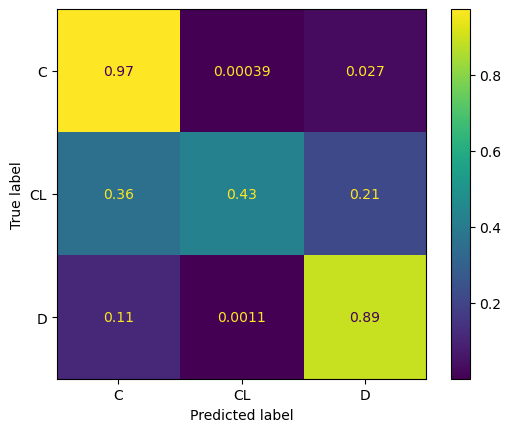

In [19]:
y_hat = xgb_cl.predict(df_train_final[FEATS])
ConfusionMatrixDisplay.from_predictions(df_train_final[LABEL], y_hat, normalize='true', display_labels=['C','CL','D'])
plt.show()

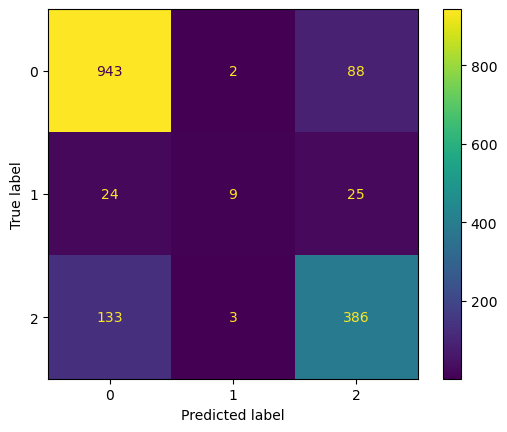

In [20]:
cm_xgb = confusion_matrix(y_val, y_val_pred, labels=xgb_final_tuning.classes_)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,
                                  display_labels=xgb_final_tuning.classes_)
disp_xgb.plot()
plt.show()

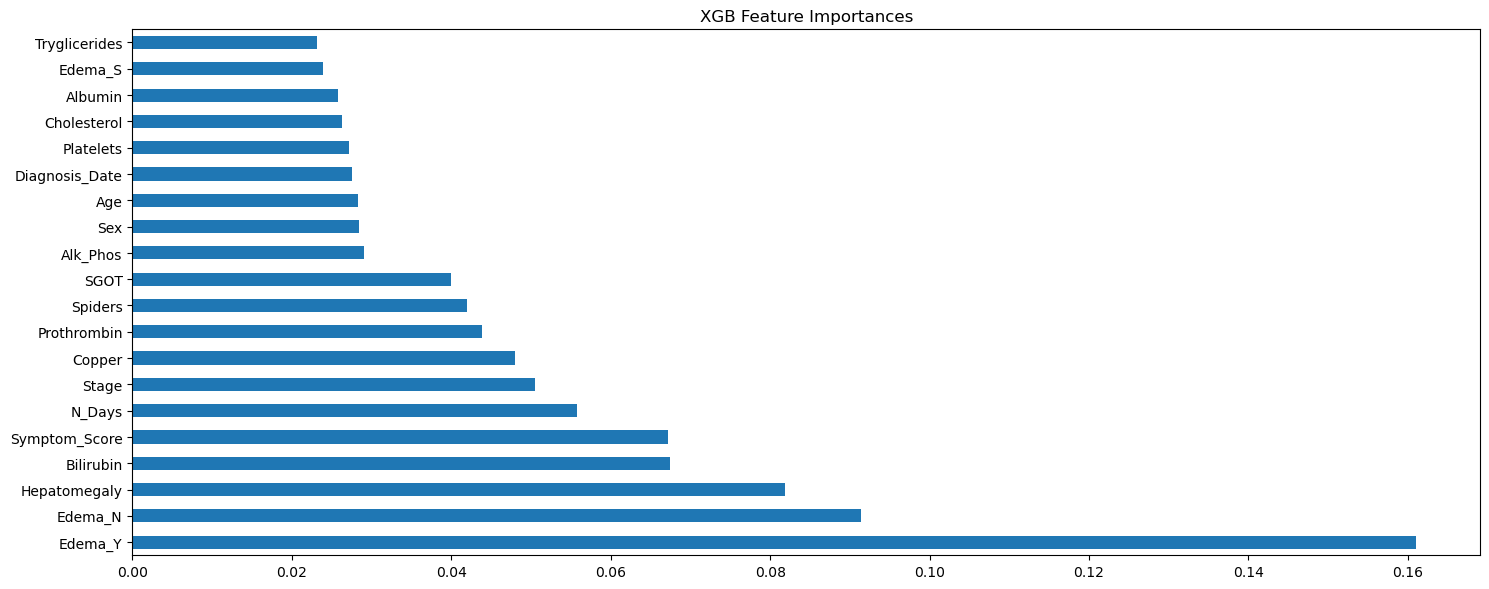

Total sorted XGBClassifier importances: ['Edema_Y', 'Edema_N', 'Hepatomegaly', 'Bilirubin', 'Symptom_Score', 'N_Days', 'Stage', 'Copper', 'Prothrombin', 'Spiders', 'SGOT', 'Alk_Phos', 'Sex', 'Age', 'Diagnosis_Date', 'Platelets', 'Cholesterol', 'Albumin', 'Edema_S', 'Tryglicerides', 'Drug']


In [21]:
xgb_feat_importances = pd.Series(xgb_cl.feature_importances_, index=df_train_final[FEATS].columns)

# Plotting both feature importances in subplots
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

xgb_feat_importances.nlargest(20).plot(kind='barh', title='XGB Feature Importances')

plt.tight_layout()
plt.show()
print(f"Total sorted XGBClassifier importances: {xgb_feat_importances.nlargest(99).index.tolist()}")

### Save the model into pickle file

In [23]:
# import pickle

with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_final_tuning, f)

In [24]:
# with open('xgb_model.pkl', 'rb') as f:
#     model = pickle.load(f)

## Catboost

In [27]:
from catboost import CatBoostClassifier, CatBoostRegressor

In [25]:
%%time

cat_params = {
    'iterations': 440,
     'depth': 8,
     'min_data_in_leaf': 37,
     'learning_rate': 0.066811646968983,
     'random_strength': 0.10809515336656547
}

cat_cl = CatBoostClassifier(**cat_params)
models = [
    {"name": "cat_cl", "model": cat_cl, "feats": FEATS},
]
models, train_scores, val_scores = validate_models(models=models, 
                                                   data=df_train_final, 
                                                   n_splits=10,
                                                   n_repeats=1)

Processing cat_cl...: 100%|███████████| 1/1 [00:41<00:00, 41.14s/it, Fold 10/10]

CPU times: user 3min 25s, sys: 5.81 s, total: 3min 31s
Wall time: 41.1 s


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

eps = .05
hl = .4
min_score = train_scores.min().min()-eps
max_score = val_scores.max().max()+eps

def calculate_ticks(min_score, max_score, num_ticks=10):
    return np.linspace(min_score, max_score, num_ticks)

ticks = calculate_ticks(min_score, max_score)

_ = sns.boxplot(train_scores, ax=axes[0])
_ = axes[0].set_title('Train Scores')
_ = axes[0].set_ylim(min_score, max_score)
_ = axes[0].set_yticks(ticks)
_ = axes[0].yaxis.grid(True)
_ = axes[0].axhline(y=0.4, color='r', linestyle='--', lw=.7)
_ = axes[0].text(-1, hl, f"{hl}", c="red")

_ = sns.boxplot(val_scores, ax=axes[1])
_ = axes[1].set_title('Validation Scores')
_ = axes[1].set_ylim(min_score, max_score)
_ = axes[1].set_yticks(ticks)
_ = axes[1].yaxis.grid(True)
_ = axes[1].axhline(y=0.4, color='r', linestyle='--', lw=.7)
_ = axes[1].text(-1, hl, f"{hl}", c="red")

In [ ]:
# Print results in DataFrame
model_res = pd.concat([train_scores.describe(), val_scores.describe()], axis=1)
model_res.columns = ['Train', 'Validation']
print(model_res)

# Plot results as lineplot
_ = sns.lineplot(pd.concat([train_scores, val_scores], keys=["Train Score", "Validation Score"], axis=1), markers=True, dashes=False)
plt.axhline(y=0.4, color='r', linestyle='--', lw=.5)
plt.title('Train vs Validation Scores')
plt.grid()
plt.xlabel('Index')
plt.ylabel('Scores')
plt.show()

In [ ]:
cat_train_scores, cat_val_scores = train_scores, val_scores
cat_total_scores = pd.concat([cat_train_scores, cat_val_scores],axis=1)

cat_total_scores.columns.values[0] = "Train scores"
cat_total_scores.columns.values[1] = "Val scores"

cat_total_scores = pd.concat([cat_total_scores, data_x_label_df], axis=1)
cat_total_scores

sns.barplot(x= "split", y="Val scores", data=cat_total_scores, 
            label= "Val scores", color='orange',bottom=0,alpha=0.7)
sns.barplot(x= "split", y="Train scores", data=cat_total_scores, 
            label= "Train scores", color='blue',edgecolor='orange', alpha=0.7)
plt.grid()
plt.ylim(0.2, 0.55)
plt.ylabel("Total Scores")
plt.legend()
plt.show()

In [28]:
cat_final_tuning = catboost.CatBoostClassifier(**cat_params)

cat_final_tuning.fit(X_train, y_train)
y_val_pred = cat_final_tuning.predict(X_val)
acc_cat = accuracy_score(y_val, y_val_pred)
print("Accuracy:",acc_cat)
cr_cat=classification_report(y_val, y_val_pred)
print("Classification report:\n",cr_cat)

NameError: name 'catboost' is not defined

In [ ]:
y_hat = cat_cl.predict(df_train_final[FEATS])
ConfusionMatrixDisplay.from_predictions(df_train_final[LABEL], y_hat, normalize='true', display_labels=['C','CL','D'])
plt.show()

In [ ]:
cm_cat = confusion_matrix(y_val, y_val_pred, labels=cat_final_tuning.classes_)
disp_cat = ConfusionMatrixDisplay(confusion_matrix=cm_cat,
                                  display_labels=cat_final_tuning.classes_)
disp_cat.plot()
plt.show()

In [ ]:
cat_feat_importances = pd.Series(cat_cl.feature_importances_, index=df_train_final[FEATS].columns)

# Plotting both feature importances in subplots
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

cat_feat_importances.nlargest(20).plot(kind='barh', title='CatBoost Feature Importances')

plt.tight_layout()
plt.show()
print(f"Total sorted XGBClassifier importances: {cat_feat_importances.nlargest(99).index.tolist()}")

## Lgbm

In [ ]:
%%time

lgb_params = {
    'n_estimators': 167,
     'max_depth': 33,
     'learning_rate': 0.035587236958871754,
     'reg_alpha': 0.0063702400826607455,
     'reg_lambda': 0.003622601223698469,
     'min_child_weight': 0.5324716296617535,
     'min_child_samples': 86,
     'subsample': 0.6322679072761366,
     'subsample_freq': 5,
     'colsample_bytree': 0.2575403028982689,
     'num_leaves': 34
}

lgb_cl = lgb.LGBMClassifier(**lgb_params)
models = [
    {"name": "lgb_cl", "model": lgb_cl, "feats": FEATS},
]
models, train_scores, val_scores = validate_models(models=models, 
                                                   data=df_train_final, 
                                                   n_splits=10,
                                                   n_repeats=1)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

eps = .05
hl = .4
min_score = train_scores.min().min()-eps
max_score = val_scores.max().max()+eps

def calculate_ticks(min_score, max_score, num_ticks=10):
    return np.linspace(min_score, max_score, num_ticks)

ticks = calculate_ticks(min_score, max_score)

_ = sns.boxplot(train_scores, ax=axes[0])
_ = axes[0].set_title('Train Scores')
_ = axes[0].set_ylim(min_score, max_score)
_ = axes[0].set_yticks(ticks)
_ = axes[0].yaxis.grid(True)
_ = axes[0].axhline(y=0.4, color='r', linestyle='--', lw=.7)
_ = axes[0].text(-1, hl, f"{hl}", c="red")

_ = sns.boxplot(val_scores, ax=axes[1])
_ = axes[1].set_title('Validation Scores')
_ = axes[1].set_ylim(min_score, max_score)
_ = axes[1].set_yticks(ticks)
_ = axes[1].yaxis.grid(True)
_ = axes[1].axhline(y=0.4, color='r', linestyle='--', lw=.7)
_ = axes[1].text(-1, hl, f"{hl}", c="red")

In [ ]:
# Print results in DataFrame
model_res = pd.concat([train_scores.describe(), val_scores.describe()], axis=1)
model_res.columns = ['Train', 'Validation']
print(model_res)

# Plot results as lineplot
_ = sns.lineplot(pd.concat([train_scores, val_scores], keys=["Train Score", "Validation Score"], axis=1), markers=True, dashes=False)
plt.axhline(y=0.4, color='r', linestyle='--', lw=.5)
plt.title('Train vs Validation Scores')
plt.grid()
plt.xlabel('Index')
plt.ylabel('Scores')
plt.show()

In [ ]:
lgb_train_scores, lgb_val_scores = train_scores, val_scores
lgb_total_scores = pd.concat([lgb_train_scores, lgb_val_scores],axis=1)

lgb_total_scores.columns.values[0] = "Train scores"
lgb_total_scores.columns.values[1] = "Val scores"

lgb_total_scores = pd.concat([lgb_total_scores, data_x_label_df], axis=1)
lgb_total_scores

sns.barplot(x= "split", y="Val scores", data=lgb_total_scores, 
            label= "Val scores", color='orange',bottom=0,alpha=0.7)
sns.barplot(x= "split", y="Train scores", data=lgb_total_scores, 
            label= "Train scores", color='blue',edgecolor='orange', alpha=0.7)
plt.grid()
plt.ylim(0.2, 0.55)
plt.ylabel("Total Scores")
plt.legend()
plt.show()

In [ ]:
lgb_final_tuning = lightgbm.LGBMClassifier(**lgb_params)

lgb_final_tuning.fit(X_train, y_train)
y_val_pred = lgb_final_tuning.predict(X_val)
acc_lgb = accuracy_score(y_val, y_val_pred)
print("Accuracy:",acc_lgb)
cr_lgb=classification_report(y_val, y_val_pred)
print("Classification report:\n",cr_lgb)

In [ ]:
y_hat = lgb_cl.predict(df_train_final[FEATS])
ConfusionMatrixDisplay.from_predictions(df_train_final[LABEL], y_hat, normalize='true', display_labels=['C','CL','D'])
plt.show()

In [ ]:
cm_lgb = confusion_matrix(y_val, y_val_pred, labels=lgb_final_tuning.classes_)
disp_lgb = ConfusionMatrixDisplay(confusion_matrix=cm_lgb,
                                  display_labels=lgb_final_tuning.classes_)
disp_lgb.plot()
plt.show()

In [ ]:
lgb_feat_importances = pd.Series(lgb_cl.feature_importances_, index=df_train_final[FEATS].columns)

# Plotting both feature importances in subplots
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

lgb_feat_importances.nlargest(20).plot(kind='barh', title='LightGBM Feature Importances')

plt.tight_layout()
plt.show()
print(f"Total sorted XGBClassifier importances: {lgb_feat_importances.nlargest(99).index.tolist()}")